#### The blotter package is primarily designed for daily or low frequency intraday trading. This is a simple illustration of an intraday backtest trading AUDUSD.

In [1]:
%pylab inline
import sys
sys.path.append("..")
from blotter import blotter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
blt = blotter.Blotter(prices="./prices", interest_rates="daily_interest_rates.csv", eod_time=None)
blt.connect_market_data()

Populating the interactive namespace from numpy and matplotlib


In [2]:
blt.define_generic("AUDUSD", ccy="USD", margin=0, multiplier=1,
                       commission=2.5, isFX=True)
blt.define_generic("USDJPY", ccy="JPY", margin=0, multiplier=1,
                       commission=2.5, isFX=True)
blt.map_instrument(generic="AUDUSD", instrument="AUDUSD")

In [3]:
aud = pd.read_csv("AUDUSD-1min.csv", parse_dates=True, index_col=0)

In [4]:
aud.head()

,bid,ask
timestamp,,
2017-01-02 00:00:00,0.72096,0.72188
2017-01-02 00:01:00,0.72096,0.72188
2017-01-02 00:02:00,0.72096,0.72188
2017-01-02 00:03:00,0.72096,0.72188
2017-01-02 00:04:00,0.72096,0.72188


In [5]:
aud.loc[:, "mid"] = (aud.loc[:, "bid"] + aud.loc[:, "ask"]) / 2

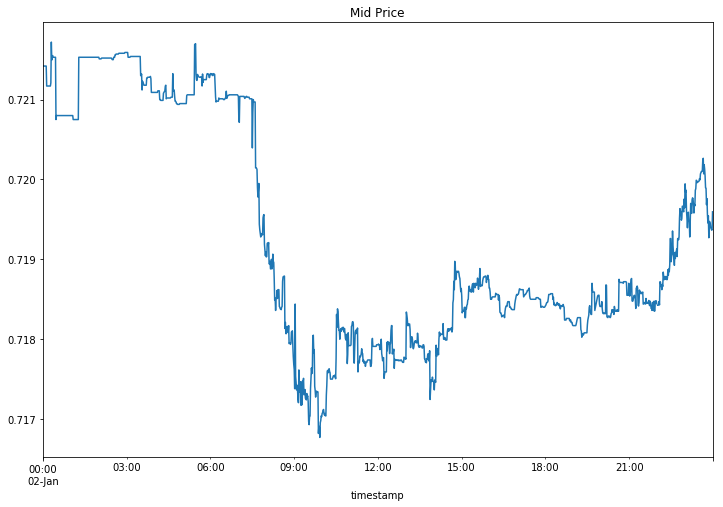

In [6]:
aud.loc[:, "mid"].plot(title="Mid Price", figsize=(12, 8))

#### Discard illiquid price action at the start of the day

In [7]:
aud = aud.loc["2017-01-02T04:00:00":]

#### Calculate 20 minute momentum

In [8]:
rets = np.log(aud.loc[:, "mid"] / aud.loc[:, "mid"].shift(20))

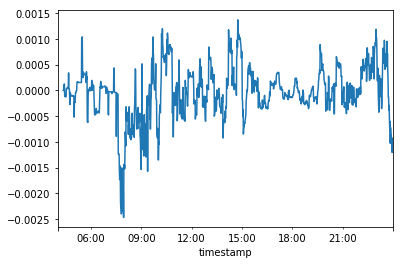

In [9]:
rets.plot()

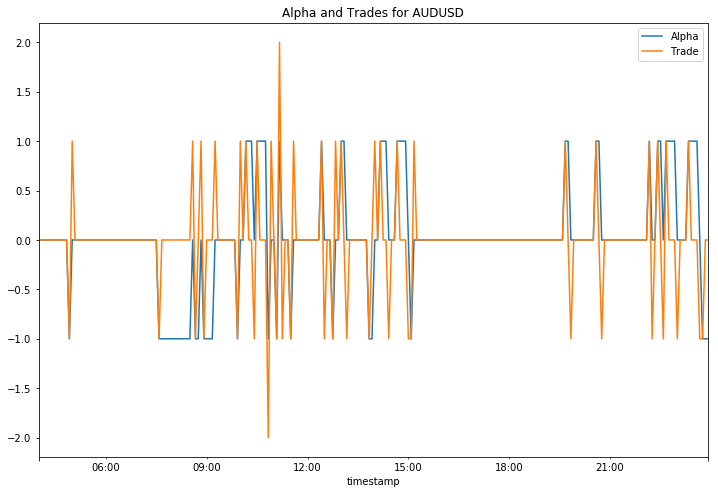

In [10]:
rets[np.abs(rets) < 0.0005] = 0
aud_alpha = np.sign(rets).fillna(value=0)
aud_alpha = aud_alpha.resample("5T").last()
aud_trd = (aud_alpha - aud_alpha.shift(1)).fillna(value=0)

signal = pd.concat([aud_alpha, aud_trd], axis=1)
signal.columns = ["Alpha", "Trade"]
signal.plot(title="Alpha and Trades for AUDUSD", figsize=(12, 8))

In [11]:
signal.tail()

,Alpha,Trade
timestamp,,
2017-01-02 23:35:00,1.0,0.0
2017-01-02 23:40:00,0.0,-1.0
2017-01-02 23:45:00,-1.0,-1.0
2017-01-02 23:50:00,-1.0,0.0
2017-01-02 23:55:00,-1.0,0.0


In [12]:
def get_price(prices, trade, ts):
    if trade > 0:
        return prices.loc[ts, "ask"]
    if trade < 0:
        return prices.loc[ts, "bid"]
    if trade == 0:
        return None

#### The automatic events schedule only supports PnL calculations once per day however we can mannually calculate PnL multiple times per day

In [13]:
for ts, trd in signal.loc[:, "Trade"].iteritems():
    price = get_price(aud, trd, ts)
    blt.trade(ts, "AUDUSD", trd*1000000, price)
    # save intraday PnL calculations
    blt.dispatch_events(blt.create_events(ts, "PNL"))

In [14]:
blt.get_instruments()

AUDUSD   -1000000.0
dtype: float64

#### Close Positions at end of Day

In [15]:
pos = blt.get_instruments()
trd = -float(pos)
ts = pd.Timestamp("2017-01-02T23:59:00")
price = get_price(aud, trd, ts)
blt.trade(ts, "AUDUSD", trd, price)

In [16]:
pnls = blt.get_pnl_history()
pnls["USD"]

,pnl,closed pnl,open pnl
2017-01-02 04:55:00,-312.50000,-2.50000,-310.0
2017-01-02 05:00:00,-625.00000,-625.00000,0.0
2017-01-02 05:05:00,-625.00000,-625.00000,0.0
2017-01-02 05:10:00,-625.00000,-625.00000,0.0
2017-01-02 05:15:00,-625.00000,-625.00000,0.0
...,...,...,...
2017-01-02 23:35:00,-2612.53637,-2962.53637,350.0
2017-01-02 23:40:00,-2685.03637,-2685.03637,0.0
2017-01-02 23:45:00,-2737.53637,-2687.53637,-50.0
2017-01-02 23:50:00,-2392.53637,-2687.53637,295.0


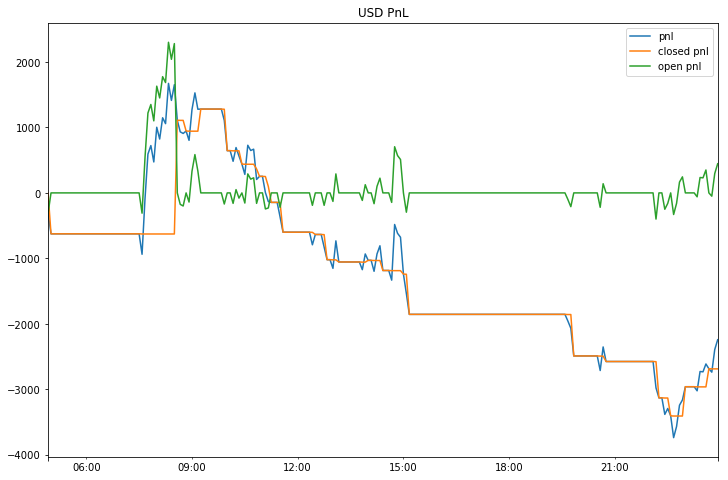

In [17]:
pnls["USD"].plot(title="USD PnL", figsize=(12,8))

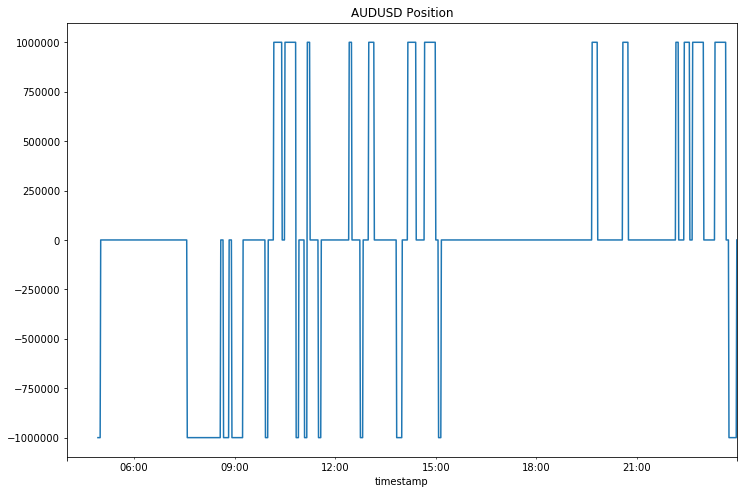

In [18]:
positions = blt.get_holdings_history()
aud_pos = positions["USD"]["AUDUSD"]
aud_pos.reindex(aud.index, method="ffill").plot(title="AUDUSD Position", figsize=(12,8))